In [1]:
import phyflow as pf
import phyflow.monte_carlo as mc
import phyflow.phy_flow_matching as pfm
from pathlib import Path
import math
import torch
from pytorch_lightning import seed_everything
from torch._inductor import config
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomVerticalFlip
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import logging

In [2]:
trash = []
seed_everything(3407, workers=True)
torch.set_float32_matmul_precision('high')
config.trace.log_autotuning_results = False
torch._logging.set_logs(inductor=logging.WARNING)
sympy_interp_logger = logging.getLogger("torch.utils._sympy.interp")
sympy_interp_logger.setLevel(logging.ERROR)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
pf.get_complete_device_info()

2025-08-18 21:52:22,429 - INFO - Seed set to 3407


      Complete Device and Firmware Information
Operating System: Linux 6.6.87.2-microsoft-standard-WSL2
Architecture: x86_64
CPU Model: x86_64
CPU Full Model: AMD Ryzen 9 9950X 16-Core Processor
PyTorch Version: 2.7.1+cu128
CUDA Status: Available
CUDA Version (used by PyTorch): 12.8
Number of GPUs Available: 1
--- GPU 0 ---
  GPU Model: NVIDIA GeForce RTX 4080
  Total Memory: 17.17 GB
  Allocated Memory: 0.00 GB
  Cached Memory (Reserved): 0.00 GB
cuDNN Version: 90701


# Increase Sample Density Lab

### Prepare the save path

In [3]:
save_root = './'
save_folder_name = 'increase_sample_density_log'
pf.create_directory(root_path=save_root, folder_name=save_folder_name)
fm_save_dir_root = Path(save_root) / save_folder_name
precision_0_05_path = 'precision_0_05'
precision_0_10_path = 'precision_0_10'
precision_0_50_path = 'precision_0_50'
pf.create_directory(root_path=fm_save_dir_root, folder_name=precision_0_05_path)
pf.create_directory(root_path=fm_save_dir_root, folder_name=precision_0_10_path)
pf.create_directory(root_path=fm_save_dir_root, folder_name=precision_0_50_path)
fm_save_dir_root_precision_0_05 = fm_save_dir_root / precision_0_05_path
fm_save_dir_root_precision_0_10 = fm_save_dir_root / precision_0_10_path
fm_save_dir_root_precision_0_50 = fm_save_dir_root / precision_0_50_path

### Prepare the Monte Carlo data of the XY model

In [4]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 32
T_start = 0.1
T_end = 2.0
precision = 0.05
ensemble_number = 5000

2025-08-18 21:52:22,589 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [5]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
)
trash.append(xy_generator)

2025-08-18 21:52:22,785 - INFO - --- Simulation Parameters for XYModel ---
2025-08-18 21:52:22,786 - INFO - Lattice size (L): 32
2025-08-18 21:52:22,786 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.05, steps: 38)
2025-08-18 21:52:22,787 - INFO - Device: cuda:0
2025-08-18 21:52:22,787 - INFO - Ensemble number per T: 5000
2025-08-18 21:52:22,788 - INFO - Number of chains (n_chains): 10
2025-08-18 21:52:22,788 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-08-18 21:52:22,789 - INFO - Calculated tau: 2048.0, tau_eff: 10.0
2025-08-18 21:52:22,790 - INFO - Thermalization sweeps (n_therm): 61440 (factor: 30)
2025-08-18 21:52:22,790 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-08-18 21:52:22,791 - INFO - Production sweeps (n_sweeps): 9500
2025-08-18 21:52:22,791 - INFO - -----------------------------------------------------
2025-08-18 21:52:22,869 - INFO - Starting Monte Carlo simulation...


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=38, ChainsPerTemp=10, AMP=True, PT=True, LargeSim=False
Starting simulation: 61440 thermalization sweeps, 9500 production sweeps.
Thermalization phase...
Production phase...


2025-08-18 21:53:56,679 - INFO - Simulation finished. Elapsed time: 93.81 s
2025-08-18 21:53:56,680 - INFO - Generated samples shape: torch.Size([38, 5000, 32, 32])
2025-08-18 21:53:56,682 - INFO - Ensured directory exists: mc_data
2025-08-18 21:53:56,684 - INFO - Ensured directory exists: mc_data/XYModel
2025-08-18 21:53:56,686 - INFO - Ensured directory exists: mc_data/XYModel/field_config
2025-08-18 21:53:56,689 - INFO - Ensured directory exists: mc_data/XYModel/measurement
2025-08-18 21:53:56,690 - INFO - Saving field configurations to: mc_data/XYModel/field_config/XYModel_L32_T0_100-2_000_prec0_050_ens5000_configs.pt
2025-08-18 21:53:56,691 - INFO - Configs tensor shape: torch.Size([38, 5000, 32, 32])
2025-08-18 21:53:56,691 - INFO - Labels tensor shape: torch.Size([38, 2])


Simulation finished. Collected 5000 samples.
labels shape: torch.Size([38, 2])
first label pair: tensor([ 0.1000, 32.0000])


2025-08-18 21:54:00,428 - INFO - Field configurations saved.
2025-08-18 21:54:00,429 - INFO - Performing measurements...
2025-08-18 21:54:01,838 - INFO - Measurements complete.
2025-08-18 21:54:01,838 - INFO - Saving measurements dictionary to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_050_ens5000_measurements.pt
2025-08-18 21:54:01,843 - INFO - Measurements dictionary saved.
2025-08-18 21:54:01,844 - INFO - Saving plots to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_050_ens5000_plots.png
2025-08-18 21:54:02,466 - INFO - Plots saved.
2025-08-18 21:54:02,671 - INFO - Cleared CUDA cache.
2025-08-18 21:54:02,672 - INFO - MCDataGenerator call finished. Total time: 100.03 s


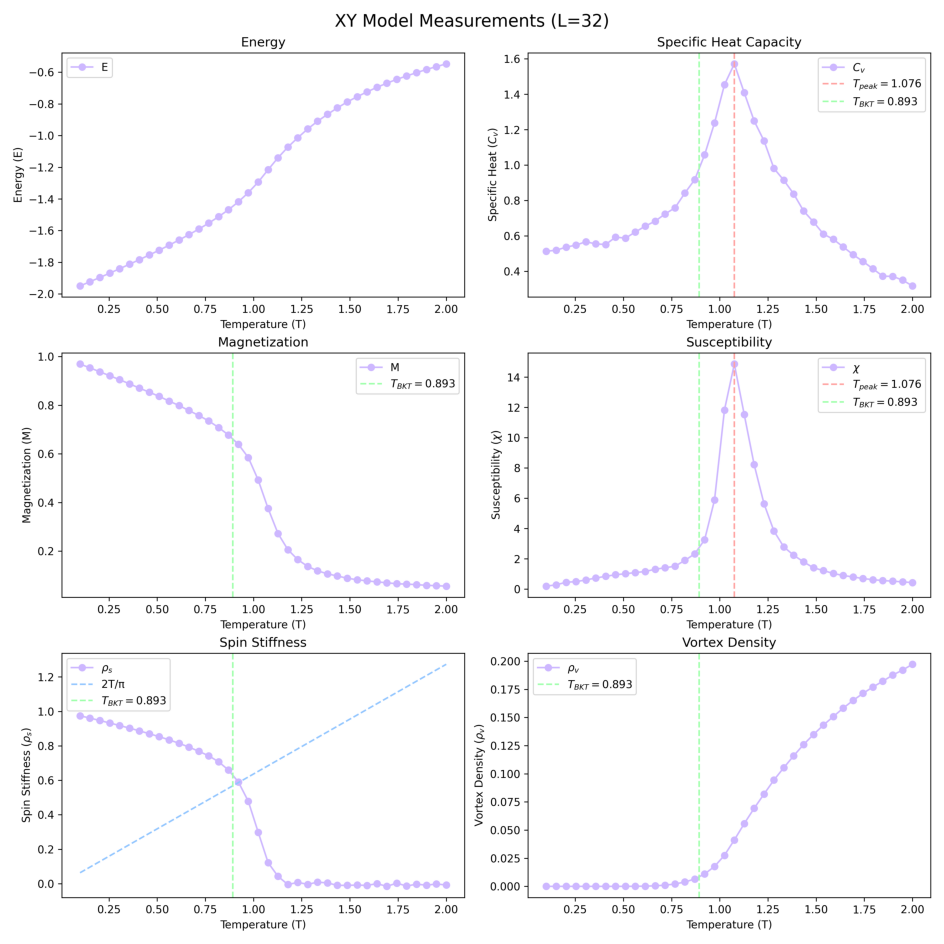

In [6]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [7]:
xy_spin_config_0_05 = mc_config_results['configs']
labels_0_05 = mc_config_results['labels']
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)

xy_spin_config_0_05.shape

torch.Size([38, 5000, 32, 32])

In [8]:
trash.append(mc_config_results)
pf.clear_cuda_cache(trash)
trash = []

### Prepare the neural network

In [9]:
num_conditions = 1

model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'downsample_out_ch_mult': (1, 1, 2,),
    'start_attn_level': 2,
    'num_blocks': 1,
    'dropout': 0.2,
    'num_heads': 4,
    'num_conditions': num_conditions,
    'emb_dim': 32,
    'padding_mode': 'circular',
}

model_0_05 = pfm.FlowUNet(**model_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, L, L, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [torch.randn(32, device="cuda") for _ in range(num_conditions)]
}

pf.profile_model(model_0_05, dummy_inputs)

Parameters:                           214.65 K
FLOPs (floating point operations):    0.9776 G
Estimated memory usage (params only): 0.82 MB


In [10]:
# from torch.profiler import profile, record_function, ProfilerActivity
#
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.1)
#
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_forward"):
#         outputs = model(**dummy_inputs)
#     with record_function("loss_backward"):
#         loss = outputs.sum()
#         loss.backward()
#     with record_function("optimizer_step"):
#         optimizer.step()
#
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
#
# prof.export_chrome_trace("trace.json")

#### Model Architecture

In [11]:
pf.check_model(model_0_05)

FlowUNet(
  (time_embedder): SinusoidalPosEmb()
  (time_mlp_embedders): MLPEmbedder(
    (mlp_emb_in_layer): Linear(in_features=32, out_features=128, bias=True)
    (mlp_emb_act): SiLU()
    (mlp_emb_out_layer): Linear(in_features=128, out_features=32, bias=True)
  )
  (cond_pos_embedders): ModuleList(
    (0): SinusoidalPosEmb()
  )
  (cond_mlp_embedders): ModuleList(
    (0): MLPEmbedder(
      (mlp_emb_in_layer): Linear(in_features=32, out_features=128, bias=True)
      (mlp_emb_act): SiLU()
      (mlp_emb_out_layer): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (mlp_msa): ConditionalMSAWithRoPE(
    (norm): RMSNorm((32,), eps=1e-06, elementwise_affine=True)
    (seq_expand_proj): Linear(in_features=2, out_features=32, bias=True)
    (qkv_projection): Linear(in_features=32, out_features=96, bias=False)
    (rope): RoPE()
    (seq_combine_proj): Linear(in_features=32, out_features=1, bias=False)
  )
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padd

### Prepare the dataset

In [12]:
t_focus_start_1 = 0.0
t_focus_end_1 = 1.38
t_focus_start_index_1 = len(T[T <= t_focus_start_1])
t_focus_end_index_1 = len(T[T <= t_focus_end_1])

In [13]:
labels_selected_0_05 = labels_0_05[:, 0]

transform_1 = Compose([
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    RandomHorizontalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    RandomVerticalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

xy_dataset_raw = mc.MCDataset(
    data=xy_spin_config_0_05,
    labels=labels_selected_0_05,
)

xy_dataset_transform_1 = mc.MCDataset(
    data=xy_spin_config_0_05,
    labels=labels_selected_0_05,
    transform=transform_1,
)

xy_spin_config_0_05_focus = xy_spin_config_0_05[t_focus_start_index_1:t_focus_end_index_1, ...]
labels_selected_0_05_focus = labels_selected_0_05[t_focus_start_index_1:t_focus_end_index_1, ...]

reps = math.ceil(xy_spin_config_0_05.shape[0] / xy_spin_config_0_05_focus.shape[0])
repeated_config_focus = xy_spin_config_0_05_focus.repeat(reps,1,1,1)[:xy_spin_config_0_05.shape[0], ...]
repeated_labels_focus = labels_selected_0_05_focus.repeat(reps)[:xy_spin_config_0_05.shape[0], ...]

xy_dataset_focus_1_transform_1 = mc.MCDataset(
    data=repeated_config_focus,
    labels=repeated_labels_focus,
    transform=transform_1,
)

xy_dataset = ConcatDataset([
    xy_dataset_raw,
    xy_dataset_transform_1,
    xy_dataset_focus_1_transform_1
])

batch_size = 32
batch_size_mod = pf.find_closest_factor(len(xy_dataset), batch_size)
print(f"Optimal batch size: {batch_size_mod}")

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size_mod,shuffle=True)

trash.append(xy_spin_config_0_05_focus)
pf.clear_cuda_cache(trash)
trash = []

Optimal batch size: 30


In [14]:
def random_global_rotate(x: torch.Tensor) -> torch.Tensor:
    """Apply a random global rotation (phase shift) to each 2-D field in a batch.

    The same random scalar θ ∈ [0, 2π) is added to **all** spatial positions
    in each sample.  After the shift, the result is wrapped into the range
    `[0, 2π)` with a modulo operation.

    Args:
        x (torch.Tensor): Input tensor of shape **(B, 1, H, W)** and any
            floating‐point dtype.

    Returns:
        torch.Tensor: Tensor with the same shape, dtype, and device as `x`,
        where for every *b* in `0 … B-1`

        ```text
        y[b, 0, :, :] = (x[b, 0, :, :] + θ_b) mod 2π.
        ```

    Notes:
        * The function is fully differentiable.
        * If `x` requires gradients, the returned tensor will as well.

    """
    if x.ndim != 4 or x.size(1) != 1:
        raise ValueError(
            f"Expected input of shape (B, 1, H, W); got {tuple(x.shape)}"
        )

    # Draw B independent scalars θ_b ∈ [0, 2π) with the same dtype/device as `x`.
    theta: torch.Tensor = torch.rand(
        x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device
    ) * (2 * torch.pi)

    # Add and wrap into [0, 2π).
    y: torch.Tensor = torch.fmod(x + theta, 2 * torch.pi)

    return (y - torch.pi) / torch.pi  # Shift to [-1, 1] range for better training stability.
    # return y

### Prepare the flow matching executor

In [15]:
gradient_accumulation_steps = 4
base_lr = gradient_accumulation_steps * 2e-4
total_epochs = 10

# init optimizer
optimizer = torch.optim.AdamW(model_0_05.parameters(), lr=base_lr, weight_decay=0.1)

scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=base_lr,
    total_steps=total_epochs+1,
    pct_start=1/3
)

fmex_0_05 = pfm.CFMExecutor(
    save_dir_root=fm_save_dir_root_precision_0_05,
    model_params=model_parameter_dict,
    model=model_0_05,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-08-18 21:54:15,033 - INFO - Save directory root 'increase_sample_density_log/precision_0_05' confirmed/created.
2025-08-18 21:54:15,034 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-08-18 21:54:15,035 - INFO - CFMExecutor initialized. Device: cuda:0
2025-08-18 21:54:15,035 - INFO - Save directory root: increase_sample_density_log/precision_0_05
2025-08-18 21:54:15,035 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


### Train the model

In [16]:
fmex_0_05.train(
    train_loaders=(
        xy_dataloader,
    ),
    num_epochs=total_epochs,
    save_every_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    mu_logit=0.0,
    sigma_logit = 1.0,
    data_argumentation_fn=random_global_rotate
)

2025-08-18 21:54:15,121 - INFO - Total batches per epoch from all loaders: 19000
2025-08-18 21:54:15,122 - INFO - Effective batch size (approx, based on first loader): 120
2025-08-18 21:54:15,122 - INFO - Starting training for 10 epochs.
2025-08-18 21:54:15,123 - INFO - Gradient Accumulation Steps: 4
2025-08-18 21:54:15,123 - INFO - Using logit-normal sampler with mu_logit=0.0000, sigma_logit=1.0000. This controls the sampling distribution for time t.
2025-08-18 21:58:22,915 - INFO - Epoch 1/10 completed in 247.79s.                                            
2025-08-18 21:58:22,916 - INFO -   Average Epoch Loss: 0.7862
2025-08-18 21:58:22,917 - INFO -   Optimizer steps in epoch: 4750
2025-08-18 21:58:22,917 - INFO -   Last AutoClip threshold used: 0.3406
2025-08-18 21:58:22,918 - INFO -   LR scheduler stepped. New LR: 0.000269
2025-08-18 21:58:22,918 - INFO - ------------------------------------------------------------
2025-08-18 21:58:22,919 - INFO - Keeping sigma_logit = 1.0000 for 

### Sample with the trained model

#### Sample with 5 step

In [17]:
fmex_0_05.load_checkpoint(fm_save_dir_root_precision_0_05/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 32
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 5000
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1 
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model_0_05,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex_0_05.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)

sol_time_start = time.time()
sol = fmex_0_05.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_time_end = time.time()
torch.cuda.empty_cache()
print(f'Solving time for L={L}: {sol_time_end - sol_time_start:.2f} seconds')

2025-08-18 22:34:36,393 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-08-18 22:34:36,394 - INFO - Loaded checkpoint from increase_sample_density_log/precision_0_05/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-08-18 22:34:36,394 - INFO - Training will resume from epoch 11.
2025-08-18 22:34:36,395 - INFO -   Last recorded average epoch loss: 0.5401
2025-08-18 22:34:36,395 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.2, 'num_heads': 4, 'num_conditions': 1, 'emb_dim': 32, 'padding_mode': 'circular'}


num_temp: 190
Optimal batch size: 626
Optimal batch size (modify): 625


2025-08-18 22:34:41,985 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-08-18 22:34:41,986 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-08-18 22:34:41,986 - INFO - Starting sample generation (solving ODE)...
2025-08-18 22:34:41,987 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-08-18 22:34:41,989 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-08-18 22:34:41,991 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-08-18 22:34:43,900 - INFO - GPU warmup completed. Returning empty tensor.
2025-08-18 22:34:43,906 - INFO - Using the original model's velocity field (via wrapper) 

Solving time for L=32: 482.27 seconds


In [18]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
# sampler_xy.spins = sol
trash.append(sol)

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


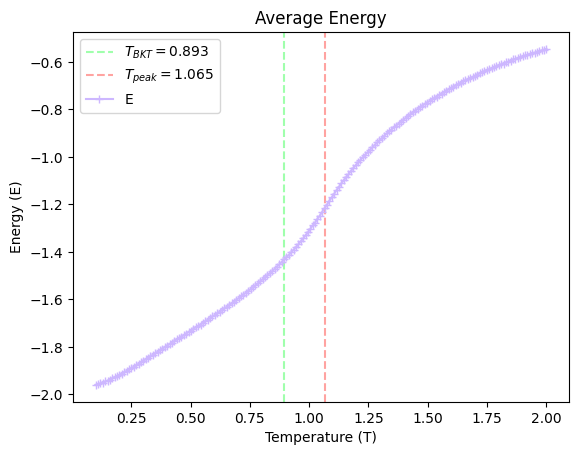

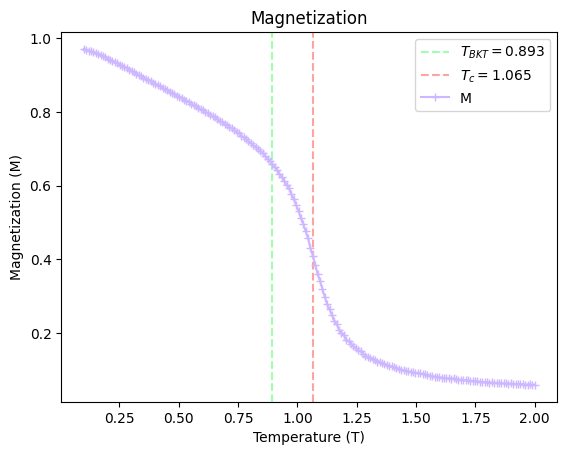

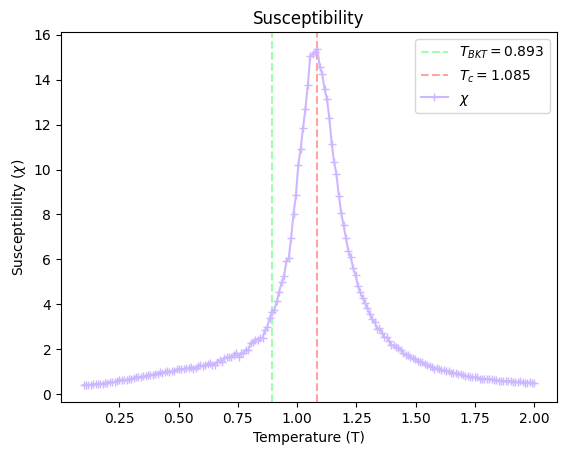

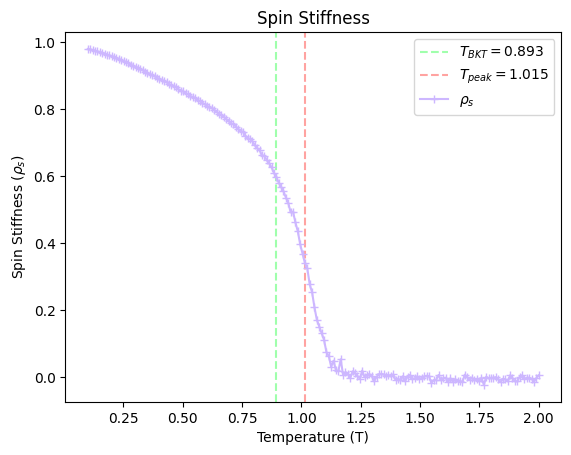

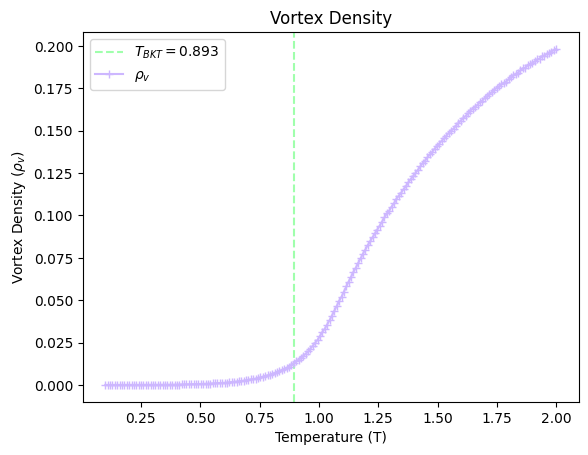

In [19]:
fm_energy_0_05 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_0_05 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_0_05 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_0_05 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_0_05 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

### Compare the results between flow matching and Monte Carlo

In [20]:
mc_temperature_0_05 = mc_measure_results['temperature']
mc_energy_0_05 = mc_measure_results['energy']
mc_specific_heat_0_05 = mc_measure_results['specific_heat']
mc_magnetization_0_05 = mc_measure_results['magnetization']
mc_susceptibility_0_05 = mc_measure_results['susceptibility']
mc_stiffness_0_05 = mc_measure_results['spin_stiffness']
mc_vortex_density_0_05 = mc_measure_results['vortex_density']

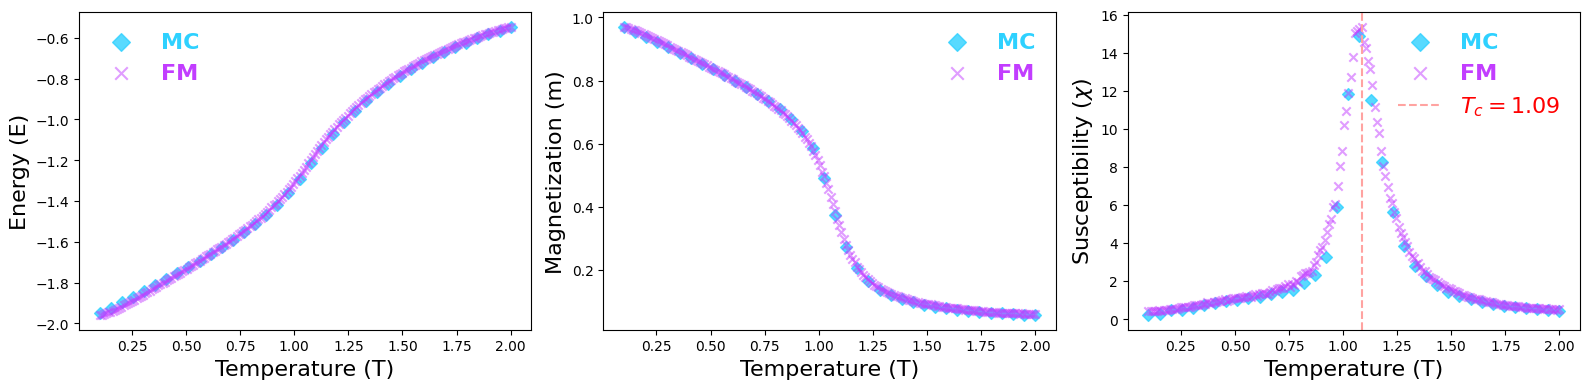

In [73]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

Temp_0_05 = Temp.cpu()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].scatter(mc_temperature_0_05, mc_energy_0_05, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp_0_05, fm_energy_0_05, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_temperature_0_05, mc_magnetization_0_05, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp_0_05, fm_magnetization_0_05, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_temperature_0_05, mc_susceptibility_0_05, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp_0_05, fm_susceptibility_0_05, marker='x', label='FM', color=fm_color, alpha=0.5)
peak_chi_idx = fm_susceptibility_0_05.argmax()
ax[2].axvline(Temp_0_05[peak_chi_idx], color='#FFA3A1', linestyle='--',
               label=f'$T_{{c}}={Temp_0_05[peak_chi_idx]:.2f}$')
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax[2].set_title('Susceptibility', fontsize=16)

for i in range(3):
    ax[i].set_xlabel('Temperature (T)', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color, 'r'],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

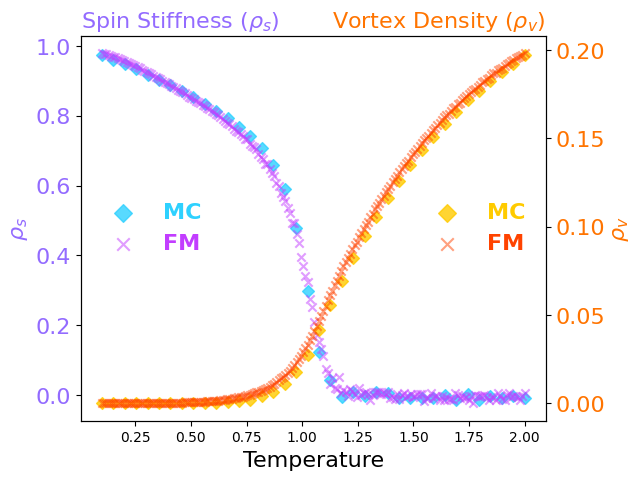

In [22]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF' 

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_temperature_0_05, mc_stiffness_0_05, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp_0_05, fm_stiffness_0_05, marker='x', label='FM', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
# ax1.set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'Spin Stiffness ($\rho_s$)', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
    loc='center left',
    prop={'weight': 'bold', 'size': 16},
    labelcolor=[mc_stiffness_color, fm_stiffness_color],
    markerscale=1.5,
    frameon=False
)

ax2 = ax1.twinx()
ax2.scatter(mc_temperature_0_05, mc_vortex_density_0_05, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp_0_05, fm_vortex_density_0_05, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.5)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
# ax2.set_ylabel(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
    loc='center right',
    prop={'weight': 'bold', 'size': 16},
    labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
    markerscale=1.5,
    frameon=False
)

plt.show()

In [23]:
def mse_mae_estimator(fm_data_list, mc_data_list):
    """
    Calculate the MSE and MAE between flow matching and Monte Carlo data.

    Args:
        fm_data_list (list): List of flow matching data tensors.
        mc_data_list (list): List of Monte Carlo data tensors.

    Returns:
        tuple: MSE and MAE values.
    """
    mse_list = []
    mae_list = []

    for fm_data, mc_data in zip(fm_data_list, mc_data_list):
        fm_tensor = torch.tensor(fm_data[::5])  # Reduce by factor of 5
        mc_tensor = torch.tensor(mc_data)

        mse = torch.nn.functional.mse_loss(fm_tensor, mc_tensor)
        mae = torch.nn.functional.l1_loss(fm_tensor, mc_tensor)

        mse_list.append(mse.item())
        mae_list.append(mae.item())

    return mse_list, mae_list

In [24]:
fm_results_list = [
    fm_energy_0_05,
    fm_magnetization_0_05,
    fm_susceptibility_0_05,
    fm_stiffness_0_05,
    fm_vortex_density_0_05,
]
mc_results_list = [
    mc_energy_0_05,
    mc_magnetization_0_05,
    mc_susceptibility_0_05,
    mc_stiffness_0_05,
    mc_vortex_density_0_05,
]

mse_list, mae_list = mse_mae_estimator(fm_results_list, mc_results_list)

print(f" Average MSE: {sum(mse_list) / len(mse_list)} ")
print(f" Average MAE: {sum(mae_list) / len(mae_list)} ")

 Average MSE: 0.10133687863356045 
 Average MAE: 0.08551878273719922 


In [25]:
trash.append(sampler_xy)
trash.append(xy_spin_config_0_05)
pf.clear_cuda_cache(trash)
trash = []

### Prepare the Monte Carlo data of the XY model with lower temperature precision

#### Precision = 0.1

In [26]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 32
T_start = 0.1
T_end = 2.0
precision = 0.1
ensemble_number = 5000

2025-08-18 22:42:54,466 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [27]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
    pt_enabled=True
)
trash.append(xy_generator)

2025-08-18 22:42:54,564 - INFO - --- Simulation Parameters for XYModel ---
2025-08-18 22:42:54,564 - INFO - Lattice size (L): 32
2025-08-18 22:42:54,565 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.1, steps: 19)
2025-08-18 22:42:54,565 - INFO - Device: cuda:0
2025-08-18 22:42:54,565 - INFO - Ensemble number per T: 5000
2025-08-18 22:42:54,566 - INFO - Number of chains (n_chains): 10
2025-08-18 22:42:54,566 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-08-18 22:42:54,567 - INFO - Calculated tau: 2048.0, tau_eff: 10.0
2025-08-18 22:42:54,567 - INFO - Thermalization sweeps (n_therm): 61440 (factor: 30)
2025-08-18 22:42:54,569 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-08-18 22:42:54,569 - INFO - Production sweeps (n_sweeps): 9500
2025-08-18 22:42:54,570 - INFO - -----------------------------------------------------
2025-08-18 22:42:54,572 - INFO - Starting Monte Carlo simulation...


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=19, ChainsPerTemp=10, AMP=True, PT=True, LargeSim=False
Starting simulation: 61440 thermalization sweeps, 9500 production sweeps.
Thermalization phase...
Production phase...
Simulation finished. Collected 5000 samples.


2025-08-18 22:44:14,236 - INFO - Simulation finished. Elapsed time: 79.66 s
2025-08-18 22:44:14,237 - INFO - Generated samples shape: torch.Size([19, 5000, 32, 32])
2025-08-18 22:44:14,238 - INFO - Ensured directory exists: mc_data
2025-08-18 22:44:14,240 - INFO - Ensured directory exists: mc_data/XYModel
2025-08-18 22:44:14,243 - INFO - Ensured directory exists: mc_data/XYModel/field_config
2025-08-18 22:44:14,246 - INFO - Ensured directory exists: mc_data/XYModel/measurement
2025-08-18 22:44:14,246 - INFO - Saving field configurations to: mc_data/XYModel/field_config/XYModel_L32_T0_100-2_000_prec0_100_ens5000_configs.pt
2025-08-18 22:44:14,247 - INFO - Configs tensor shape: torch.Size([19, 5000, 32, 32])
2025-08-18 22:44:14,247 - INFO - Labels tensor shape: torch.Size([19, 2])


labels shape: torch.Size([19, 2])
first label pair: tensor([ 0.1000, 32.0000])


2025-08-18 22:44:15,857 - INFO - Field configurations saved.
2025-08-18 22:44:15,857 - INFO - Performing measurements...
2025-08-18 22:44:17,600 - INFO - Measurements complete.
2025-08-18 22:44:17,600 - INFO - Saving measurements dictionary to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_100_ens5000_measurements.pt
2025-08-18 22:44:17,604 - INFO - Measurements dictionary saved.
2025-08-18 22:44:17,605 - INFO - Saving plots to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_100_ens5000_plots.png
2025-08-18 22:44:18,090 - INFO - Plots saved.
2025-08-18 22:44:18,413 - INFO - Cleared CUDA cache.
2025-08-18 22:44:18,414 - INFO - MCDataGenerator call finished. Total time: 83.85 s


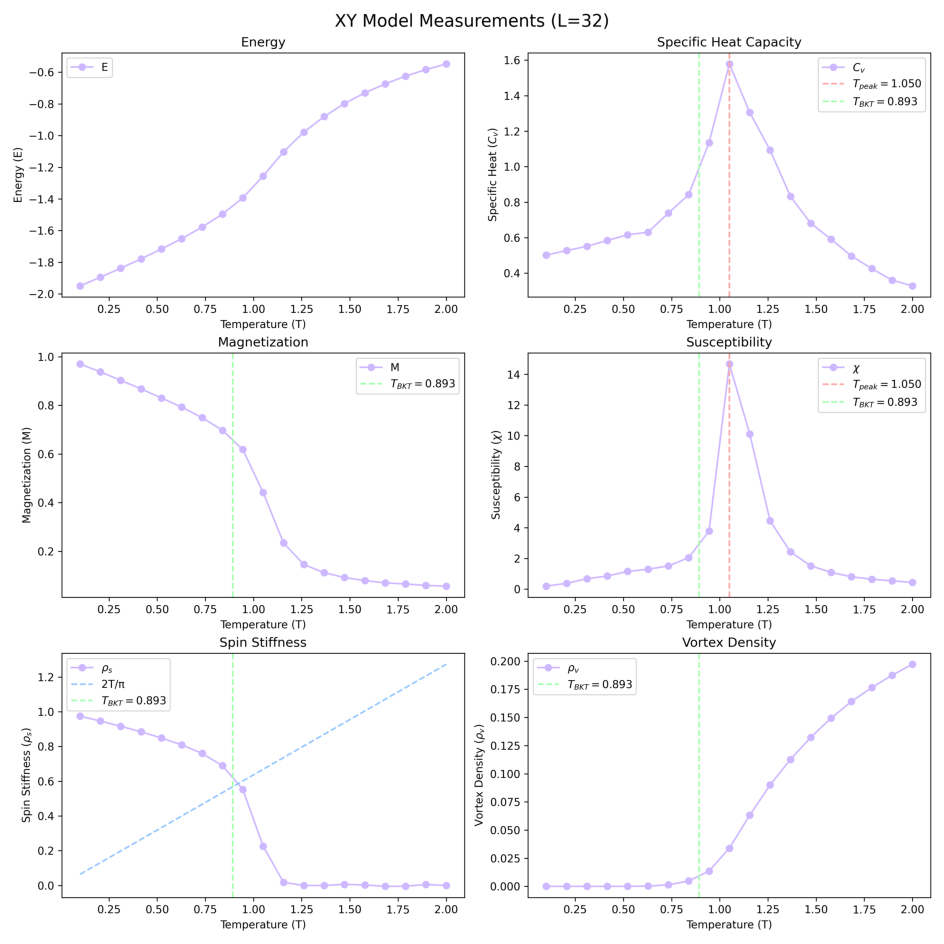

In [28]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [29]:
xy_spin_config_0_1 = mc_config_results['configs']
labels_0_1 = mc_config_results['labels']
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)

xy_spin_config_0_1.shape

torch.Size([19, 5000, 32, 32])

In [30]:
trash.append(mc_config_results)
pf.clear_cuda_cache(trash)
trash = []

In [31]:
num_conditions = 1

model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'downsample_out_ch_mult': (1, 1, 2,),
    'start_attn_level': 2,
    'num_blocks': 1,
    'dropout': 0.2,
    'num_heads': 4,
    'num_conditions': num_conditions,
    'emb_dim': 32,
    'padding_mode': 'circular',
}

model_0_1 = pfm.FlowUNet(**model_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, L, L, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [torch.randn(32, device="cuda") for _ in range(num_conditions)]
}

pf.profile_model(model_0_1, dummy_inputs)

Parameters:                           214.65 K
FLOPs (floating point operations):    0.9776 G
Estimated memory usage (params only): 0.82 MB


### Prepare the dataset

In [32]:
t_focus_start_1 = 0.0
t_focus_end_1 = 1.38
t_focus_start_index_1 = len(T[T <= t_focus_start_1])
t_focus_end_index_1 = len(T[T <= t_focus_end_1])

In [33]:
labels_selected_0_1 = labels_0_1[:, 0]

transform_1 = Compose([
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    RandomHorizontalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    RandomVerticalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

xy_dataset_raw = mc.MCDataset(
    data=xy_spin_config_0_1,
    labels=labels_selected_0_1,
)

xy_dataset_transform_1 = mc.MCDataset(
    data=xy_spin_config_0_1,
    labels=labels_selected_0_1,
    transform=transform_1,
)

xy_spin_config_0_1_focus = xy_spin_config_0_1[t_focus_start_index_1:t_focus_end_index_1, ...]
labels_selected_0_1_focus = labels_selected_0_1[t_focus_start_index_1:t_focus_end_index_1, ...]

reps = math.ceil(xy_spin_config_0_1.shape[0] / xy_spin_config_0_1_focus.shape[0])
repeated_config_focus = xy_spin_config_0_1_focus.repeat(reps,1,1,1)[:xy_spin_config_0_1.shape[0], ...]
repeated_labels_focus = labels_selected_0_1_focus.repeat(reps)[:xy_spin_config_0_1.shape[0], ...]

xy_dataset_focus_1_transform_1 = mc.MCDataset(
    data=repeated_config_focus,
    labels=repeated_labels_focus,
    transform=transform_1,
)

xy_dataset = ConcatDataset([
    xy_dataset_raw,
    xy_dataset_transform_1,
    xy_dataset_focus_1_transform_1
])

batch_size = 32
batch_size_mod = pf.find_closest_factor(len(xy_dataset), batch_size)
print(f"Optimal batch size: {batch_size_mod}")

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size_mod,shuffle=True)

trash.append(xy_spin_config_0_1_focus)
pf.clear_cuda_cache(trash)
trash = []

Optimal batch size: 30


In [34]:
gradient_accumulation_steps = 4
base_lr = gradient_accumulation_steps * 2e-4
total_epochs = 10

# init optimizer
optimizer = torch.optim.AdamW(model_0_1.parameters(), lr=base_lr, weight_decay=0.1)

scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=base_lr,
    total_steps=total_epochs+1,
    pct_start=1/3
)

fmex_0_1 = pfm.CFMExecutor(
    save_dir_root=fm_save_dir_root_precision_0_10,
    model_params=model_parameter_dict,
    model=model_0_1,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-08-18 22:44:21,232 - INFO - Save directory root 'increase_sample_density_log/precision_0_10' confirmed/created.
2025-08-18 22:44:21,234 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-08-18 22:44:21,235 - INFO - CFMExecutor initialized. Device: cuda:0
2025-08-18 22:44:21,235 - INFO - Save directory root: increase_sample_density_log/precision_0_10
2025-08-18 22:44:21,235 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


In [35]:
fmex_0_1.train(
    train_loaders=(
        xy_dataloader,
    ),
    num_epochs=total_epochs,
    save_every_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    mu_logit=0.0,
    sigma_logit = 1.0,
    data_argumentation_fn=random_global_rotate
)

2025-08-18 22:44:21,335 - INFO - Total batches per epoch from all loaders: 9500
2025-08-18 22:44:21,336 - INFO - Effective batch size (approx, based on first loader): 120
2025-08-18 22:44:21,336 - INFO - Starting training for 10 epochs.
2025-08-18 22:44:21,336 - INFO - Gradient Accumulation Steps: 4
2025-08-18 22:44:21,337 - INFO - Using logit-normal sampler with mu_logit=0.0000, sigma_logit=1.0000. This controls the sampling distribution for time t.
2025-08-18 22:46:20,699 - INFO - Epoch 1/10 completed in 119.36s.                                          
2025-08-18 22:46:20,699 - INFO -   Average Epoch Loss: 0.8895
2025-08-18 22:46:20,700 - INFO -   Optimizer steps in epoch: 2375
2025-08-18 22:46:20,700 - INFO -   Last AutoClip threshold used: 0.1888
2025-08-18 22:46:20,700 - INFO -   LR scheduler stepped. New LR: 0.000269
2025-08-18 22:46:20,701 - INFO - ------------------------------------------------------------
2025-08-18 22:46:20,701 - INFO - Keeping sigma_logit = 1.0000 for thi

In [36]:
fmex_0_1.load_checkpoint(fm_save_dir_root_precision_0_10/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 32
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 5000
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model_0_1,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex_0_1.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)

sol_time_start = time.time()
sol = fmex_0_1.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_time_end = time.time()
torch.cuda.empty_cache()
print(f'Solving time for L={L}: {sol_time_end - sol_time_start:.2f} seconds')

2025-08-18 23:04:25,050 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-08-18 23:04:25,051 - INFO - Loaded checkpoint from increase_sample_density_log/precision_0_10/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-08-18 23:04:25,051 - INFO - Training will resume from epoch 11.
2025-08-18 23:04:25,052 - INFO -   Last recorded average epoch loss: 0.5406
2025-08-18 23:04:25,052 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.2, 'num_heads': 4, 'num_conditions': 1, 'emb_dim': 32, 'padding_mode': 'circular'}


num_temp: 190
Optimal batch size: 626
Optimal batch size (modify): 625


2025-08-18 23:04:27,699 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-08-18 23:04:27,700 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-08-18 23:04:27,701 - INFO - Starting sample generation (solving ODE)...
2025-08-18 23:04:27,701 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-08-18 23:04:27,702 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-08-18 23:04:27,704 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-08-18 23:04:28,552 - INFO - GPU warmup completed. Returning empty tensor.
2025-08-18 23:04:28,558 - INFO - Using the original model's velocity field (via wrapper) 

Solving time for L=32: 480.88 seconds


In [37]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
# sampler_xy.spins = sol
trash.append(sol)

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


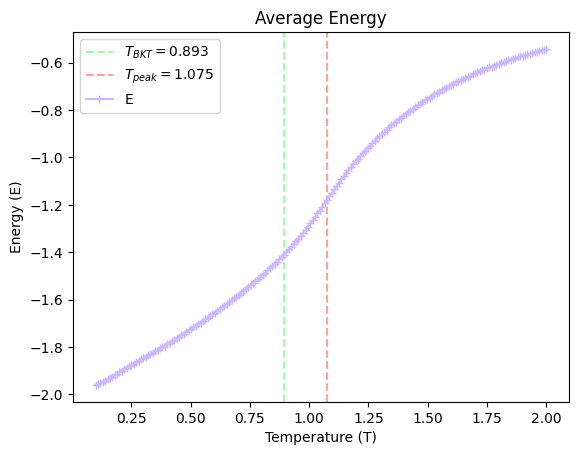

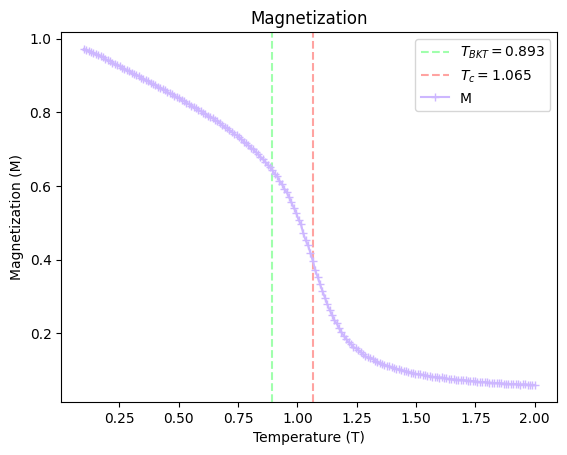

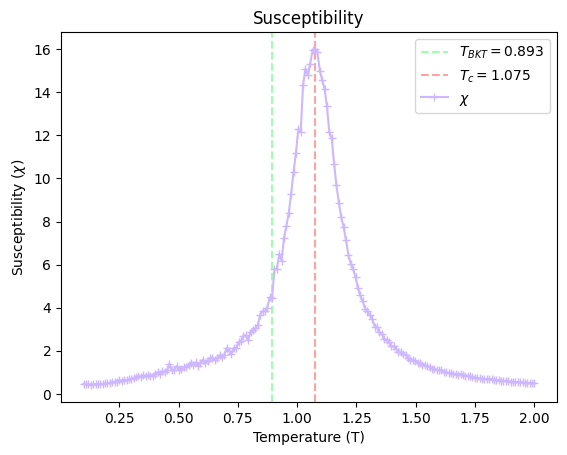

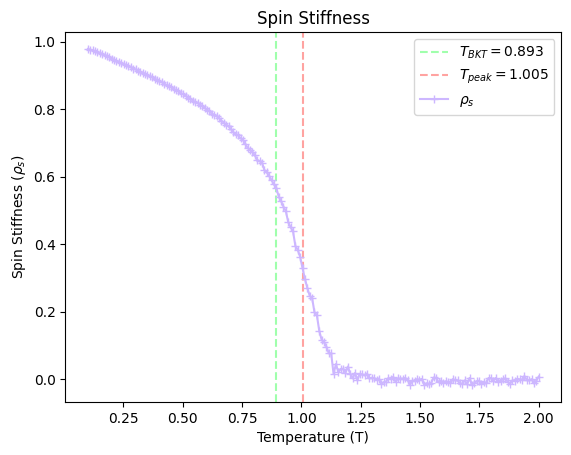

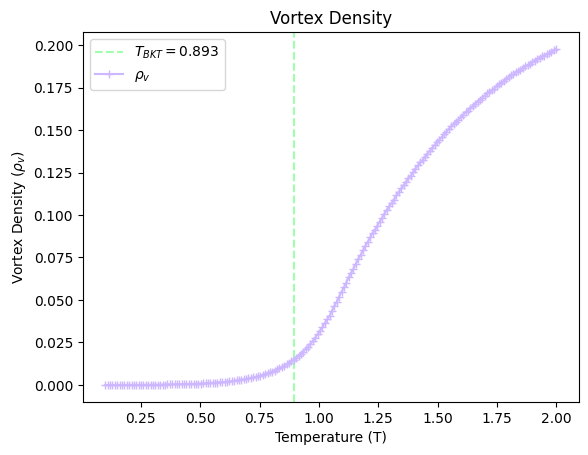

In [38]:
fm_energy_0_1 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_0_1 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_0_1 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_0_1 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_0_1 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [39]:
mc_temperature_0_1 = mc_measure_results['temperature']
mc_energy_0_1 = mc_measure_results['energy']
mc_specific_heat_0_1 = mc_measure_results['specific_heat']
mc_magnetization_0_1 = mc_measure_results['magnetization']
mc_susceptibility_0_1 = mc_measure_results['susceptibility']
mc_stiffness_0_1 = mc_measure_results['spin_stiffness']
mc_vortex_density_0_1 = mc_measure_results['vortex_density']

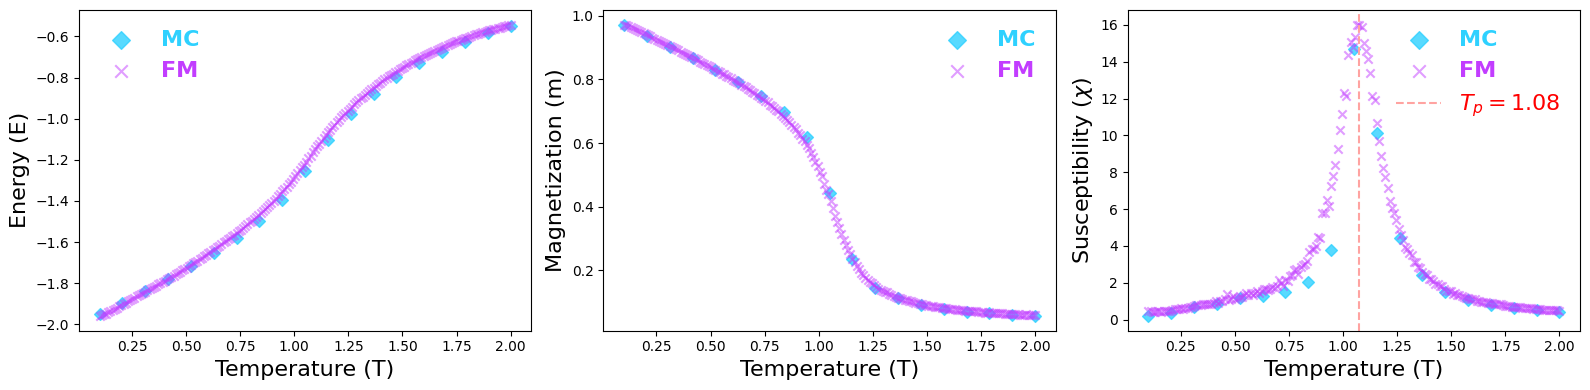

In [74]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

Temp_0_1 = Temp.cpu()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].scatter(mc_temperature_0_1, mc_energy_0_1, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp_0_1, fm_energy_0_1, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_temperature_0_1, mc_magnetization_0_1, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp_0_1, fm_magnetization_0_1, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_temperature_0_1, mc_susceptibility_0_1, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp_0_1, fm_susceptibility_0_1, marker='x', label='FM', color=fm_color, alpha=0.5)
peak_chi_idx = fm_susceptibility_0_1.argmax()
ax[2].axvline(Temp_0_1[peak_chi_idx], color='#FFA3A1', linestyle='--',
               label=f'$T_{{p}}={Temp_0_1[peak_chi_idx]:.2f}$')
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax[2].set_title('Susceptibility', fontsize=16)

for i in range(3):
    ax[i].set_xlabel('Temperature (T)', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color, 'r'],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

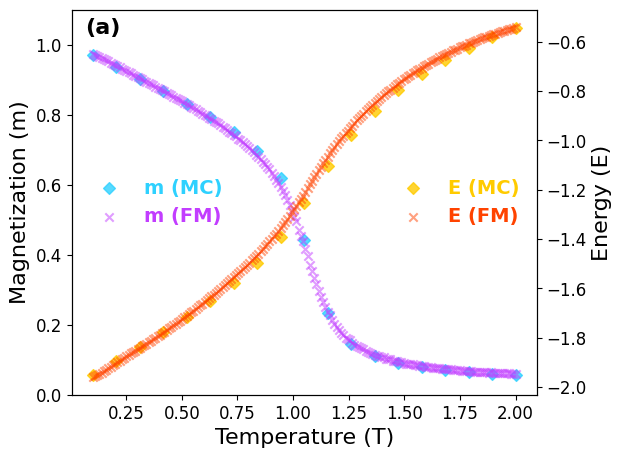

In [91]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_magnetization_color = "#2ED1FF"
fm_magnetization_color = '#C23DFF'

mc_energy_color = "#FFCB00"
fm_energy_color = "#FF4300"

magnetization_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_temperature_0_1, mc_magnetization_0_1, marker='D', label='m (MC)', color=mc_magnetization_color, alpha=0.8)
ax1.scatter(Temp_0_1, fm_magnetization_0_1, marker='x', label='m (FM)', color=fm_magnetization_color, alpha=0.5)
ax1.set_xlabel('Temperature (T)', fontsize=16)
ax1.set_ylabel('Magnetization (m)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim((0.0, 1.1))
ax1.text(0.03, 0.98, '(a)', transform=ax1.transAxes,
         fontsize=16, fontweight='bold', va='top')

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 14},
        labelcolor=[mc_magnetization_color, fm_magnetization_color],
        markerscale=1,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_temperature_0_1, mc_energy_0_1, marker='D', label='E (MC)', color=mc_energy_color, alpha=0.8)
ax2.scatter(Temp_0_1, fm_energy_0_1, marker='x', label='E (FM)', color=fm_energy_color, alpha=0.5)
ax2.set_ylabel('Energy (E)', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax2.legend(
    loc='center right',
    prop={'weight': 'bold', 'size': 14},
    labelcolor=[mc_energy_color, fm_energy_color],
    markerscale=1,
    frameon=False
)

plt.show()

<Figure size 640x480 with 0 Axes>

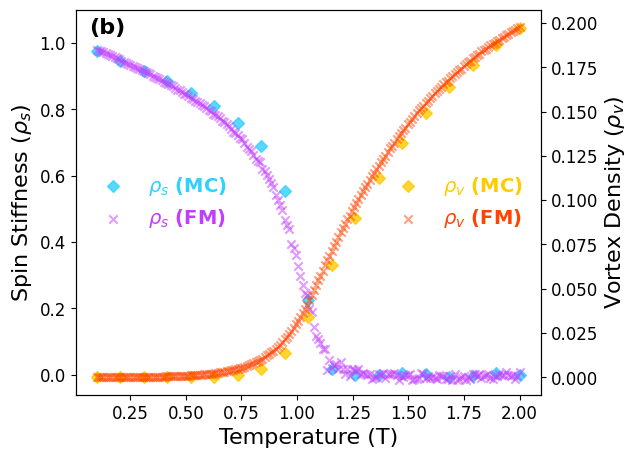

In [97]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_temperature_0_1, mc_stiffness_0_1, marker='D', label=r'$\rho_s$ (MC)', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp_0_1, fm_stiffness_0_1, marker='x', label=r'$\rho_s$ (FM)', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature (T)', fontsize=16)
# ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16)
# ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
# ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim((-0.06, 1.1))
ax1.text(0.03, 0.98, '(b)', transform=ax1.transAxes,
         fontsize=16, fontweight='bold', va='top')

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 14},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_temperature_0_1, mc_vortex_density_0_1, marker='D', label=r'$\rho_v$ (MC)', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp_0_1, fm_vortex_density_0_1, marker='x', label=r'$\rho_v$ (FM)', color=fm_vortex_density_color, alpha=0.5)
# ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_ylabel(r'Vortex Density ($\rho_v$)', fontsize=16)
# ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
# ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax2.legend(
    loc='center right',
    prop={'weight': 'bold', 'size': 14},
    labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
    markerscale=1,
    frameon=False
)

plt.show()

In [42]:
trash.append(sampler_xy)
trash.append(xy_spin_config_0_1)
pf.clear_cuda_cache(trash)
trash = []

#### Precision = 0.5

In [43]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 32
T_start = 0.1
T_end = 2.0
precision = 0.5
ensemble_number = 5000

2025-08-18 23:12:38,638 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [44]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
    pt_enabled=False
)
trash.append(xy_generator)

2025-08-18 23:12:38,753 - INFO - --- Simulation Parameters for XYModel ---
2025-08-18 23:12:38,754 - INFO - Lattice size (L): 32
2025-08-18 23:12:38,754 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.5, steps: 4)
2025-08-18 23:12:38,755 - INFO - Device: cuda:0
2025-08-18 23:12:38,755 - INFO - Ensemble number per T: 5000
2025-08-18 23:12:38,755 - INFO - Number of chains (n_chains): 10
2025-08-18 23:12:38,756 - INFO - Calculated tau: 2048.0
2025-08-18 23:12:38,756 - INFO - Thermalization sweeps (n_therm): 61440 (factor: 30)
2025-08-18 23:12:38,757 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-08-18 23:12:38,757 - INFO - Production sweeps (n_sweeps): 9500
2025-08-18 23:12:38,757 - INFO - -----------------------------------------------------
2025-08-18 23:12:38,760 - INFO - Starting Monte Carlo simulation...


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=4, ChainsPerTemp=10, AMP=True, PT=False, LargeSim=False
Starting simulation: 61440 thermalization sweeps, 9500 production sweeps.
Thermalization phase...
Production phase...
Simulation finished. Collected 5000 samples.


2025-08-18 23:13:25,498 - INFO - Simulation finished. Elapsed time: 46.74 s
2025-08-18 23:13:25,498 - INFO - Generated samples shape: torch.Size([4, 5000, 32, 32])
2025-08-18 23:13:25,500 - INFO - Ensured directory exists: mc_data
2025-08-18 23:13:25,502 - INFO - Ensured directory exists: mc_data/XYModel
2025-08-18 23:13:25,505 - INFO - Ensured directory exists: mc_data/XYModel/field_config
2025-08-18 23:13:25,508 - INFO - Ensured directory exists: mc_data/XYModel/measurement
2025-08-18 23:13:25,508 - INFO - Saving field configurations to: mc_data/XYModel/field_config/XYModel_L32_T0_100-2_000_prec0_500_ens5000_configs.pt
2025-08-18 23:13:25,509 - INFO - Configs tensor shape: torch.Size([4, 5000, 32, 32])
2025-08-18 23:13:25,509 - INFO - Labels tensor shape: torch.Size([4, 2])


labels shape: torch.Size([4, 2])
first label pair: tensor([ 0.1000, 32.0000])


2025-08-18 23:13:25,855 - INFO - Field configurations saved.
2025-08-18 23:13:25,856 - INFO - Performing measurements...
2025-08-18 23:13:27,122 - INFO - Measurements complete.
2025-08-18 23:13:27,123 - INFO - Saving measurements dictionary to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_500_ens5000_measurements.pt
2025-08-18 23:13:27,127 - INFO - Measurements dictionary saved.
2025-08-18 23:13:27,128 - INFO - Saving plots to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_500_ens5000_plots.png
2025-08-18 23:13:27,605 - INFO - Plots saved.
2025-08-18 23:13:27,915 - INFO - Cleared CUDA cache.
2025-08-18 23:13:27,916 - INFO - MCDataGenerator call finished. Total time: 49.16 s


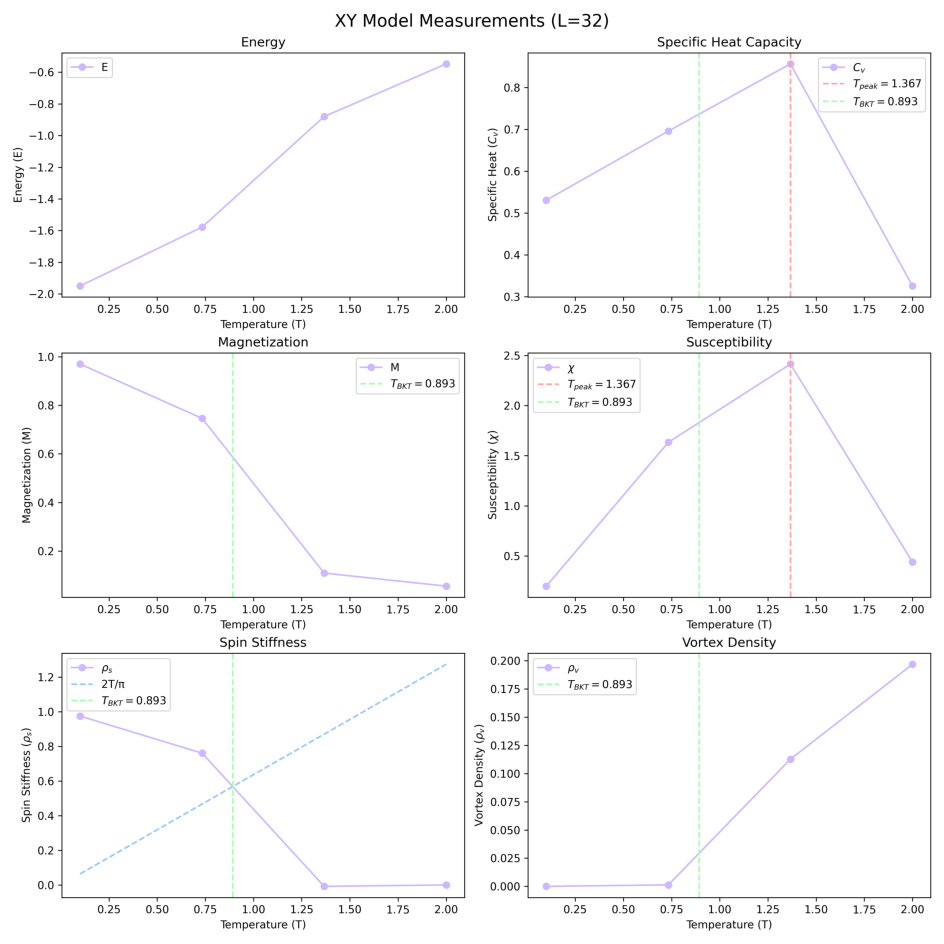

In [45]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [46]:
xy_spin_config_0_5 = mc_config_results['configs']
labels_0_5 = mc_config_results['labels']
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)

xy_spin_config_0_5.shape

torch.Size([4, 5000, 32, 32])

In [47]:
trash.append(mc_config_results)
pf.clear_cuda_cache(trash)
trash = []

In [48]:
num_conditions = 1

model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'downsample_out_ch_mult': (1, 1, 2,),
    'start_attn_level': 2,
    'num_blocks': 1,
    'dropout': 0.2,
    'num_heads': 4,
    'num_conditions': num_conditions,
    'emb_dim': 32,
    'padding_mode': 'circular',
}

model_0_5 = pfm.FlowUNet(**model_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, L, L, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [torch.randn(32, device="cuda") for _ in range(num_conditions)]
}

pf.profile_model(model_0_5, dummy_inputs)

Parameters:                           214.65 K
FLOPs (floating point operations):    0.9776 G
Estimated memory usage (params only): 0.82 MB


### Prepare the dataset

In [49]:
t_focus_start_1 = 0.0
t_focus_end_1 = 1.38
t_focus_start_index_1 = len(T[T <= t_focus_start_1])
t_focus_end_index_1 = len(T[T <= t_focus_end_1])

In [50]:
labels_selected_0_5 = labels_0_5[:, 0]

transform_1 = Compose([
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    RandomHorizontalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    RandomVerticalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

xy_dataset_raw = mc.MCDataset(
    data=xy_spin_config_0_5,
    labels=labels_selected_0_5,
)

xy_dataset_transform_1 = mc.MCDataset(
    data=xy_spin_config_0_5,
    labels=labels_selected_0_5,
    transform=transform_1,
)

xy_spin_config_0_5_focus = xy_spin_config_0_5[t_focus_start_index_1:t_focus_end_index_1, ...]
labels_selected_0_5_focus = labels_selected_0_5[t_focus_start_index_1:t_focus_end_index_1, ...]

reps = math.ceil(xy_spin_config_0_5.shape[0] / xy_spin_config_0_5_focus.shape[0])
repeated_config_focus = xy_spin_config_0_5_focus.repeat(reps,1,1,1)[:xy_spin_config_0_5.shape[0], ...]
repeated_labels_focus = labels_selected_0_5_focus.repeat(reps)[:xy_spin_config_0_5.shape[0], ...]

xy_dataset_focus_1_transform_1 = mc.MCDataset(
    data=repeated_config_focus,
    labels=repeated_labels_focus,
    transform=transform_1,
)

xy_dataset = ConcatDataset([
    xy_dataset_raw,
    xy_dataset_transform_1,
    xy_dataset_focus_1_transform_1
])

batch_size = 32
batch_size_mod = pf.find_closest_factor(len(xy_dataset), batch_size)
print(f"Optimal batch size: {batch_size_mod}")

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size_mod,shuffle=True)

trash.append(xy_spin_config_0_5_focus)
pf.clear_cuda_cache(trash)
trash = []

Optimal batch size: 32


In [51]:
gradient_accumulation_steps = 4
base_lr = gradient_accumulation_steps * 2e-4
total_epochs = 50

# init optimizer
optimizer = torch.optim.AdamW(model_0_5.parameters(), lr=base_lr, weight_decay=0.1)

scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=base_lr,
    total_steps=total_epochs+1,
    pct_start=1/3
)

fmex_0_5 = pfm.CFMExecutor(
    save_dir_root=fm_save_dir_root_precision_0_50,
    model_params=model_parameter_dict,
    model=model_0_5,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-08-18 23:13:29,857 - INFO - Save directory root 'increase_sample_density_log/precision_0_50' confirmed/created.
2025-08-18 23:13:29,859 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-08-18 23:13:29,859 - INFO - CFMExecutor initialized. Device: cuda:0
2025-08-18 23:13:29,860 - INFO - Save directory root: increase_sample_density_log/precision_0_50
2025-08-18 23:13:29,860 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


In [52]:
fmex_0_5.train(
    train_loaders=(
        xy_dataloader,
    ),
    num_epochs=total_epochs,
    save_every_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    mu_logit=0.0,
    sigma_logit = 1.0,
    data_argumentation_fn=random_global_rotate
)

2025-08-18 23:13:29,976 - INFO - Total batches per epoch from all loaders: 1875
2025-08-18 23:13:29,976 - INFO - Effective batch size (approx, based on first loader): 128
2025-08-18 23:13:29,977 - INFO - Starting training for 50 epochs.
2025-08-18 23:13:29,978 - INFO - Gradient Accumulation Steps: 4
2025-08-18 23:13:29,978 - INFO - Using logit-normal sampler with mu_logit=0.0000, sigma_logit=1.0000. This controls the sampling distribution for time t.
2025-08-18 23:13:54,589 - INFO - Epoch 1/50 completed in 24.61s.                                           
2025-08-18 23:13:54,589 - INFO -   Average Epoch Loss: 1.3416
2025-08-18 23:13:54,590 - INFO -   Optimizer steps in epoch: 469
2025-08-18 23:13:54,590 - INFO -   Last AutoClip threshold used: 0.4506
2025-08-18 23:13:54,591 - INFO -   LR scheduler stepped. New LR: 0.000039
2025-08-18 23:13:54,591 - INFO - ------------------------------------------------------------
2025-08-18 23:13:54,592 - INFO - Keeping sigma_logit = 1.0000 for this

In [53]:
fmex_0_5.load_checkpoint(fm_save_dir_root_precision_0_50/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

L = 32
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 5000
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model_0_5,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex_0_5.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
)

sol_time_start = time.time()
sol = fmex_0_5.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_time_end = time.time()
torch.cuda.empty_cache()
print(f'Solving time for L={L}: {sol_time_end - sol_time_start:.2f} seconds')

2025-08-18 23:33:36,426 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-08-18 23:33:36,427 - INFO - Loaded checkpoint from increase_sample_density_log/precision_0_50/checkpoints/checkpoint_epoch_0050.pth. Last completed epoch: 50.
2025-08-18 23:33:36,427 - INFO - Training will resume from epoch 51.
2025-08-18 23:33:36,427 - INFO -   Last recorded average epoch loss: 0.5135
2025-08-18 23:33:36,428 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.2, 'num_heads': 4, 'num_conditions': 1, 'emb_dim': 32, 'padding_mode': 'circular'}


num_temp: 190
Optimal batch size: 626
Optimal batch size (modify): 625


2025-08-18 23:33:40,888 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-08-18 23:33:40,888 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-08-18 23:33:40,889 - INFO - Starting sample generation (solving ODE)...
2025-08-18 23:33:40,889 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-08-18 23:33:40,893 - INFO -   Time Grid (Fixed Steps): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-08-18 23:33:40,894 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.8999999761581421, 1.0]
2025-08-18 23:33:41,831 - INFO - GPU warmup completed. Returning empty tensor.
2025-08-18 23:33:41,837 - INFO - Using the original model's velocity field (via wrapper) 

Solving time for L=32: 478.98 seconds


In [54]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
# sampler_xy.spins = sol
trash.append(sol)

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


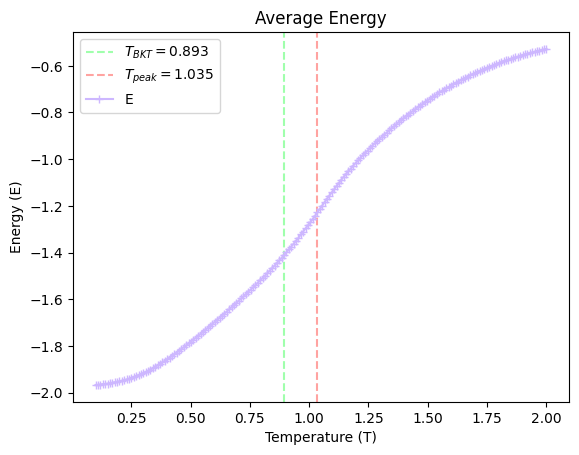

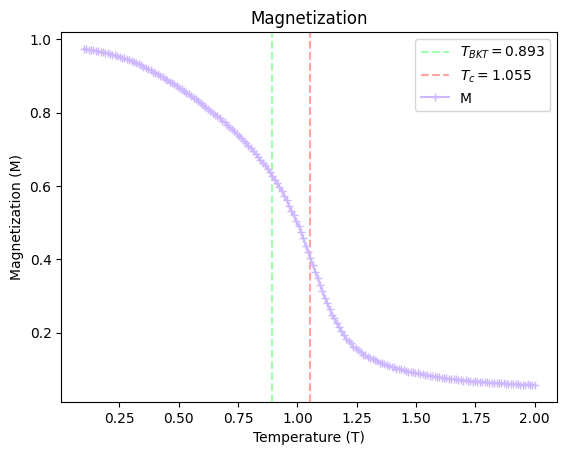

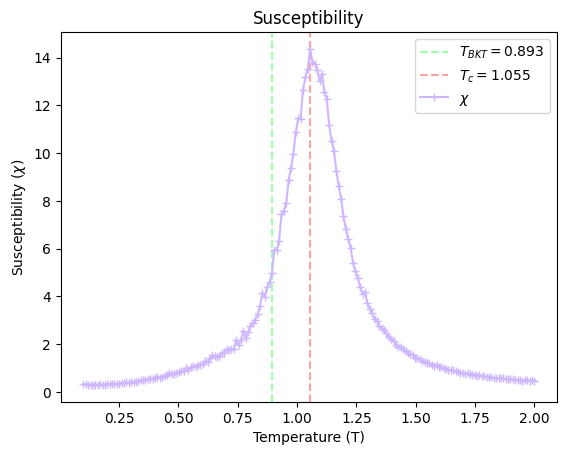

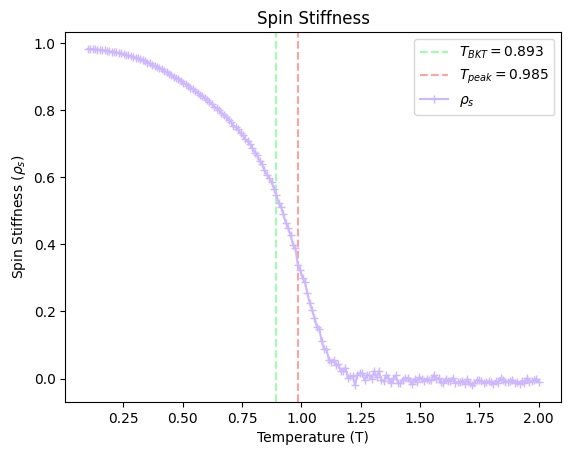

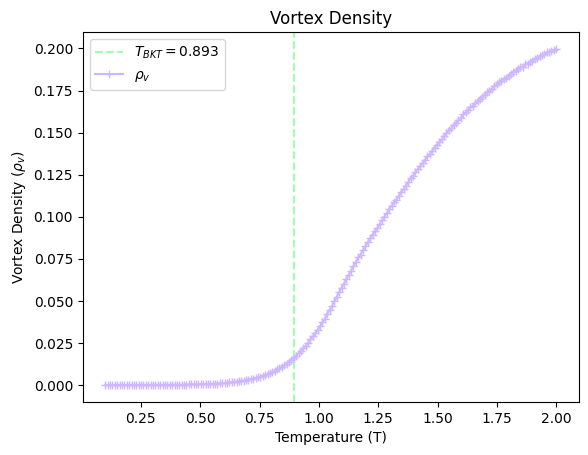

In [55]:
fm_energy_0_5 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_0_5 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_0_5 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_0_5 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_0_5 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [56]:
mc_temperature_0_5 = mc_measure_results['temperature']
mc_energy_0_5 = mc_measure_results['energy']
mc_specific_heat_0_5 = mc_measure_results['specific_heat']
mc_magnetization_0_5 = mc_measure_results['magnetization']
mc_susceptibility_0_5 = mc_measure_results['susceptibility']
mc_stiffness_0_5 = mc_measure_results['spin_stiffness']
mc_vortex_density_0_5 = mc_measure_results['vortex_density']

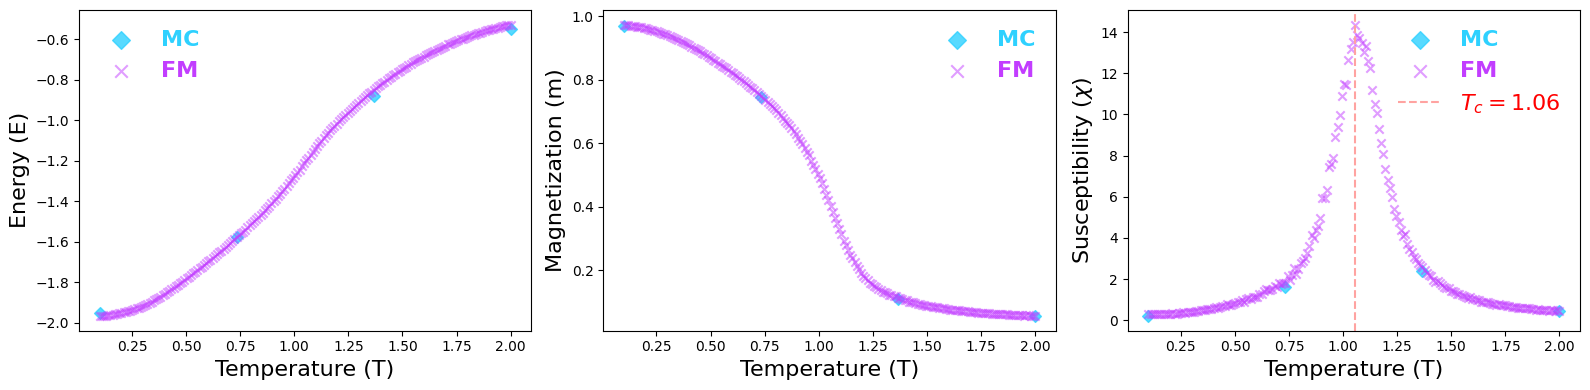

In [76]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

Temp_0_5 = Temp.cpu()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].scatter(mc_temperature_0_5, mc_energy_0_5, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp_0_5, fm_energy_0_5, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_temperature_0_5, mc_magnetization_0_5, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp_0_5, fm_magnetization_0_5, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_temperature_0_5, mc_susceptibility_0_5, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp_0_5, fm_susceptibility_0_5, marker='x', label='FM', color=fm_color, alpha=0.5)
peak_chi_idx = fm_susceptibility_0_5.argmax()
ax[2].axvline(Temp_0_5[peak_chi_idx], color='#FFA3A1', linestyle='--',
               label=f'$T_{{c}}={Temp_0_5[peak_chi_idx]:.2f}$')
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax[2].set_title('Susceptibility', fontsize=16)

for i in range(3):
    ax[i].set_xlabel('Temperature (T)', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color, 'r'],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

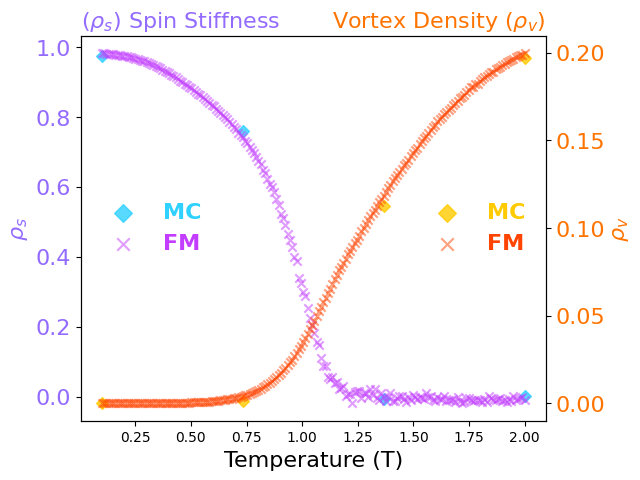

In [58]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_temperature_0_5, mc_stiffness_0_5, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp_0_5, fm_stiffness_0_5, marker='x', label='FM', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature (T)', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
# ax1.set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_temperature_0_5, mc_vortex_density_0_5, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp_0_5, fm_vortex_density_0_5, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.5)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
# ax2.set_ylabel(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
    loc='center right',
    prop={'weight': 'bold', 'size': 16},
    labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
    markerscale=1.5,
    frameon=False
)

plt.show()

In [59]:
trash.append(sampler_xy)
trash.append(xy_spin_config_0_5)
pf.clear_cuda_cache(trash)
trash = []

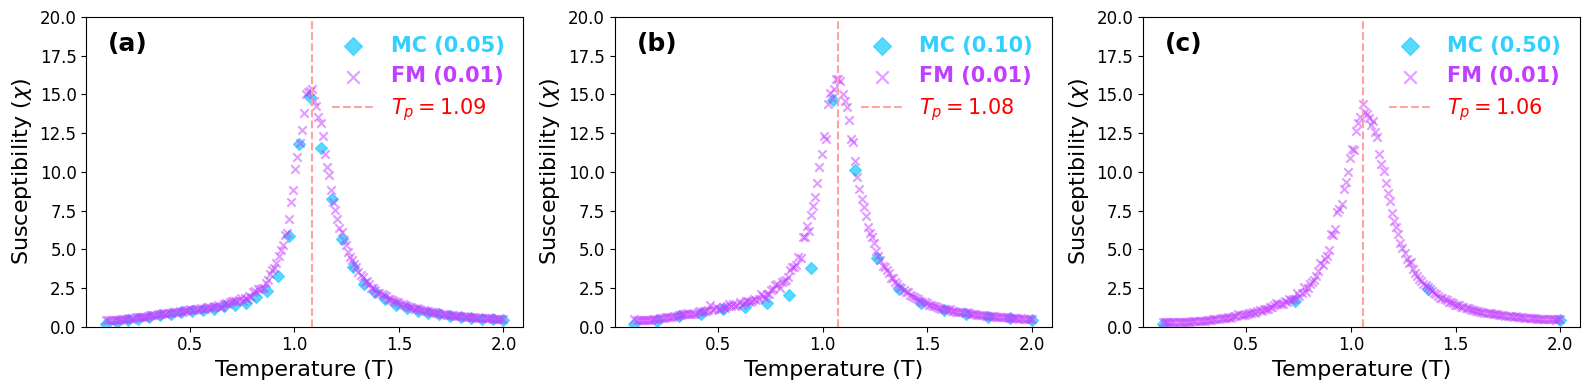

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].scatter(mc_temperature_0_05, mc_susceptibility_0_05, marker='D', label='MC (0.05)', color=mc_color, alpha=0.8)
ax[0].scatter(Temp_0_05, fm_susceptibility_0_05, marker='x', label='FM (0.01)', color=fm_color, alpha=0.5)
peak_chi_idx = fm_susceptibility_0_05.argmax()
ax[0].axvline(Temp_0_05[peak_chi_idx], color='#FFA3A1', linestyle='--',
               label=f'$T_{{p}}={Temp_0_05[peak_chi_idx]:.2f}$')
ax[0].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_ylim(0, 20)
ax[0].text(0.05, 0.95, '(a)', transform=ax[0].transAxes,
         fontsize=18, fontweight='bold', va='top')

ax[1].scatter(mc_temperature_0_1, mc_susceptibility_0_1, marker='D', label='MC (0.10)', color=mc_color, alpha=0.8)
ax[1].scatter(Temp_0_1, fm_susceptibility_0_1, marker='x', label='FM (0.01)', color=fm_color, alpha=0.5)
peak_chi_idx = fm_susceptibility_0_1.argmax()
ax[1].axvline(Temp_0_1[peak_chi_idx], color='#FFA3A1', linestyle='--',
               label=f'$T_{{p}}={Temp_0_1[peak_chi_idx]:.2f}$')
ax[1].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_ylim(0, 20)
ax[1].text(0.05, 0.95, '(b)', transform=ax[1].transAxes,
         fontsize=18, fontweight='bold', va='top')

ax[2].scatter(mc_temperature_0_5, mc_susceptibility_0_5, marker='D', label='MC (0.50)', color=mc_color, alpha=0.8)
ax[2].scatter(Temp_0_5, fm_susceptibility_0_5, marker='x', label='FM (0.01)', color=fm_color, alpha=0.5)
peak_chi_idx = fm_susceptibility_0_5.argmax()
ax[2].axvline(Temp_0_5[peak_chi_idx], color='#FFA3A1', linestyle='--',
               label=f'$T_{{p}}={Temp_0_5[peak_chi_idx]:.2f}$')
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].set_ylim(0, 20)
ax[2].text(0.05, 0.95, '(c)', transform=ax[2].transAxes,
         fontsize=18, fontweight='bold', va='top')

for i in range(3):
    ax[i].set_xlabel('Temperature (T)', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 15},
        labelcolor=[mc_color, fm_color, 'r'],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()